<a href="https://colab.research.google.com/github/shivanandiyer/DL_ImageCaptioning/blob/main/AT3_Group10_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!wget https://github.com/shivanandiyer/DL_ImageCaptioning/blob/main/Flickr8k_Dataset.zip
!wget https://github.com/shivanandiyer/DL_ImageCaptioning/blob/main/Flickr8k_text.zip


--2022-05-07 11:51:03--  https://github.com/shivanandiyer/DL_ImageCaptioning/blob/main/Flickr8k_text.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Flickr8k_text.zip.1’

Flickr8k_text.zip.1     [ <=>                ] 123.52K  --.-KB/s    in 0.08s   

2022-05-07 11:51:03 (1.60 MB/s) - ‘Flickr8k_text.zip.1’ saved [126485]



In [ ]:
#unzipping
!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

In [5]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

In [6]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("all_captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("all_captions/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("all_captions/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("all_captions/Flickr_8k.devImages.txt",names=["img_id"])

In [7]:
#just checking the number of images in the dataset
l=os.listdir("all_images/Flicker8k_Dataset")
print(len(l))

8091


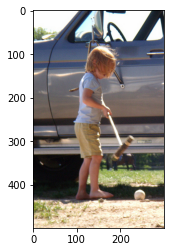

In [9]:
#visualising one of the train images
img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" +train_image_names.img_id[1])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [10]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [12]:
image_tokens["img_id"]

0        A man in street racer armor be examine the tir...
1               Two racer drive a white bike down a road .
2        Two motorist be ride along on their vehicle th...
3        Two person be in a small race car drive by a g...
4             Two person in race uniform in a street car .
                               ...                        
40455    A girl in a pool wear goggles and surround by ...
40456    A girl in green goggles in a pool with three o...
40457    A red haired girl make a peace sign be wear ne...
40458    A redheaded girl offer a peace sign as she swi...
40459    A young girl with goggles and floaties pose fo...
Name: img_caption, Length: 40460, dtype: object

In [13]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")

In [15]:
image_tokens

,img_id,img_caption
0,1305564994_00513f9a5b.jpg,<start> A man in street racer armor be examine...
1,1305564994_00513f9a5b.jpg,<start> Two racer drive a white bike down a ro...
2,1305564994_00513f9a5b.jpg,<start> Two motorist be ride along on their ve...
3,1305564994_00513f9a5b.jpg,<start> Two person be in a small race car driv...
4,1305564994_00513f9a5b.jpg,<start> Two person in race uniform in a street...
...,...,...
40455,989754491_7e53fb4586.jpg,<start> A girl in a pool wear goggles and surr...
40456,989754491_7e53fb4586.jpg,<start> A girl in green goggles in a pool with...
40457,989754491_7e53fb4586.jpg,<start> A red haired girl make a peace sign be...
40458,989754491_7e53fb4586.jpg,<start> A redheaded girl offer a peace sign as...


In [16]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:21<00:00, 277.91it/s]


In [27]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:05<00:00, 187.33it/s]


In [18]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 309.12it/s]


In [28]:
validation_captions

{'2090545563_a4e66ec76b.jpg': ['<start> the boy lay face down on a skateboard be be push along the ground by another boy . <end>',
  '<start> Two girl play on a skateboard in a courtyard . <end>',
  '<start> Two person play on a long skateboard . <end>',
  '<start> Two small child in red shirt play on a skateboard . <end>',
  '<start> two young child on a skateboard go across a sidewalk <end>'],
 '3393035454_2d2370ffd4.jpg': ['<start> a boy in a blue top be jump off some rock in the wood . <end>',
  '<start> A boy jump off a tan rock . <end>',
  '<start> A boy jump up in a field in the wood . <end>',
  '<start> A young boy jump off a rock in a forest <end>',
  '<start> Child in blue and gray shirt jump off hill in the wood <end>'],
 '3695064885_a6922f06b2.jpg': ['<start> A lady walk her dog through an obstacle course , while other person be in the background . <end>',
  '<start> A small tan and white dog and trainer run an obstacle course <end>',
  '<start> A woman be guide a brown dog

#ResNet50 model for encoding images


In [30]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#Encoding images and forming dictionaries containing mapping of image_id to image encodings


In [31]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

100%|██████████| 6000/6000 [26:28<00:00,  3.78it/s]


In [33]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_features, pickle_f )

In [34]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="all_images/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]


In [35]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(test_features, pickle_f )

In [36]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="all_images/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]


In [37]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )